# K-means Clustering

### Import resources and display image

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.metrics import silhouette_score
%matplotlib inline
BLUE = (0,0,255)
RED = (255,0,0)

### Read in an image

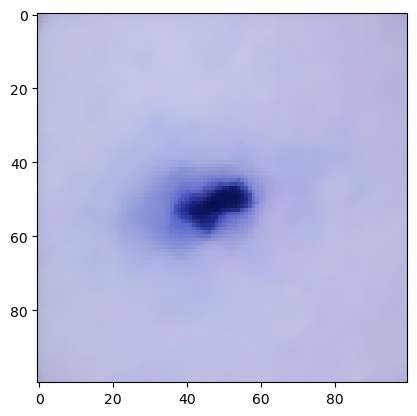

In [2]:
image = cv2.imread("0_initial.PNG")
plt.imshow(image)

### Change from BGR to RGB

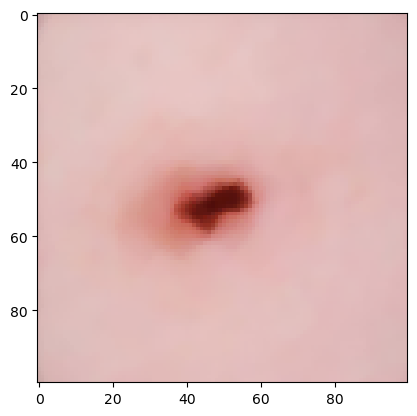

In [3]:
# Change color to RGB (from BGR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

### Preprocessing

In [4]:
# Crop (center crop)
h, w = image.shape[:2]
center_x, center_y = w//2, h//2
crop_size = min(h, w) // 2
image_cropped = image[center_y-crop_size:center_y+crop_size, center_x-crop_size:center_x+crop_size]

# Resize to standard size
image_resized = cv2.resize(image_cropped, (512, 512))

# Noise Reduction - Gaussian Blur
image_denoised = cv2.GaussianBlur(image_resized, (5, 5), 0)

# Final preprocessed image
image = image_denoised

### HSV Conversion

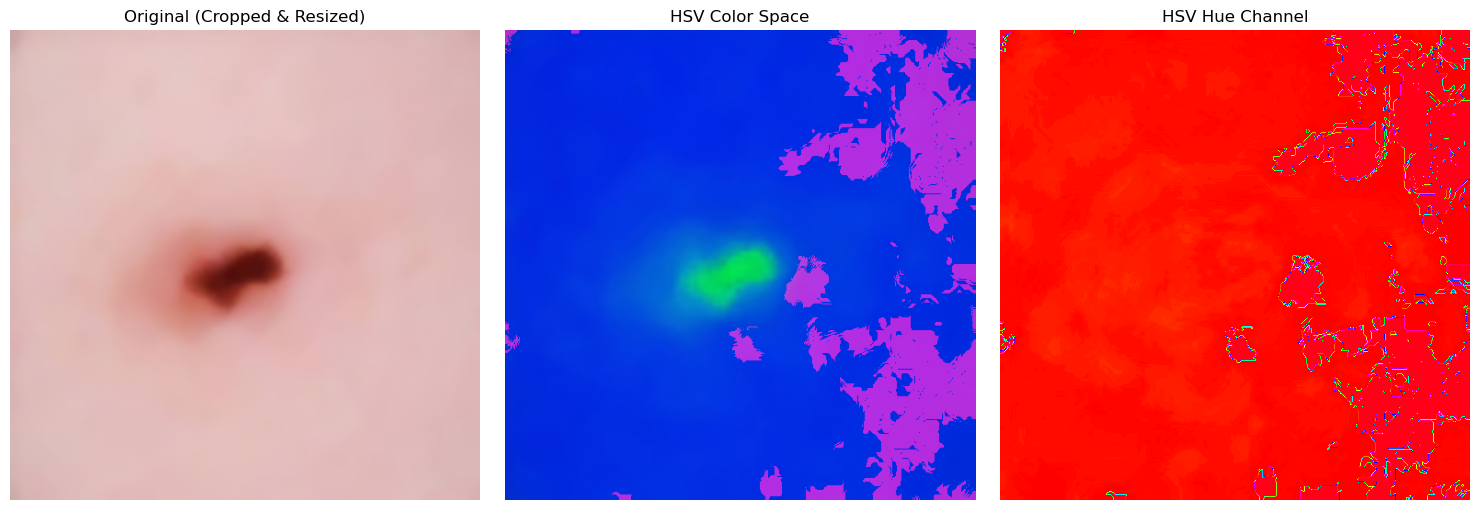

In [5]:
# HSV Conversion (RGB to HSV)
image_hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

# Display preprocessing results
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title('Original (Cropped & Resized)')
plt.imshow(image)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('HSV Color Space')
plt.imshow(image_hsv)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('HSV Hue Channel')
plt.imshow(image_hsv[:,:,0], cmap='hsv')
plt.axis('off')

plt.tight_layout()
plt.show()

### Histogram Equalization (RGB)

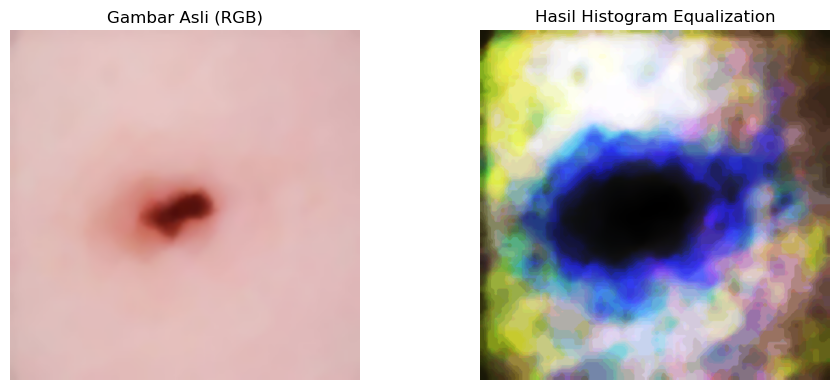

In [6]:
b, g, r = cv2.split(image)

b_eq = cv2.equalizeHist(b)
g_eq = cv2.equalizeHist(g)
r_eq = cv2.equalizeHist(r)

equalized_color = cv2.merge((b_eq, g_eq, r_eq))
equalized_color_rgb = cv2.cvtColor(equalized_color, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title('Gambar Asli (RGB)')
plt.imshow(image)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Hasil Histogram Equalization')
plt.imshow(equalized_color_rgb)
plt.axis('off')

plt.tight_layout()
plt.show()

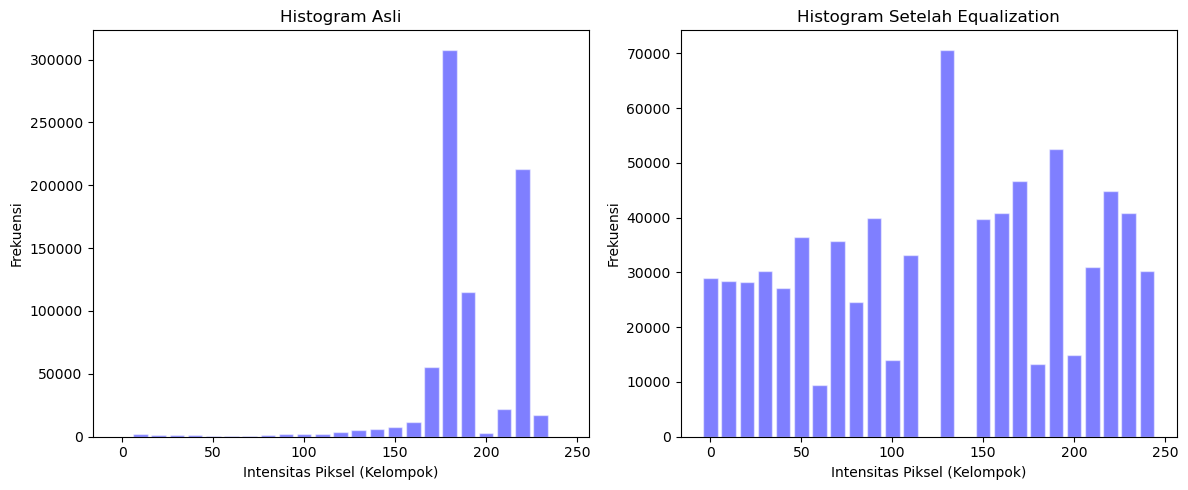

In [7]:
bin_size = 10
bins = np.arange(0, 256, bin_size)
hist_original, _ = np.histogram(image, bins=bins)
hist_equalized, _ = np.histogram(equalized_color_rgb, bins=bins)

# Plot histogram
plt.figure(figsize=(12, 5))

# Histogram Asli
plt.subplot(1, 2, 1)
plt.bar(bins[:-1], hist_original, width=8, color='blue', edgecolor='white', alpha=0.5)
plt.title("Histogram Asli")
plt.xlabel("Intensitas Piksel (Kelompok)")
plt.ylabel("Frekuensi")
plt.xticks(np.arange(0, 256, 50)) 

# Histogram Setelah Equalization
plt.subplot(1, 2, 2)
plt.bar(bins[:-1], hist_equalized, width=8, color='blue', edgecolor='white', alpha=0.5)
plt.title("Histogram Setelah Equalization")
plt.xlabel("Intensitas Piksel (Kelompok)")
plt.ylabel("Frekuensi")
plt.xticks(np.arange(0, 256, 50))

plt.tight_layout()
plt.show()

### Histogram Equlization (HSV)

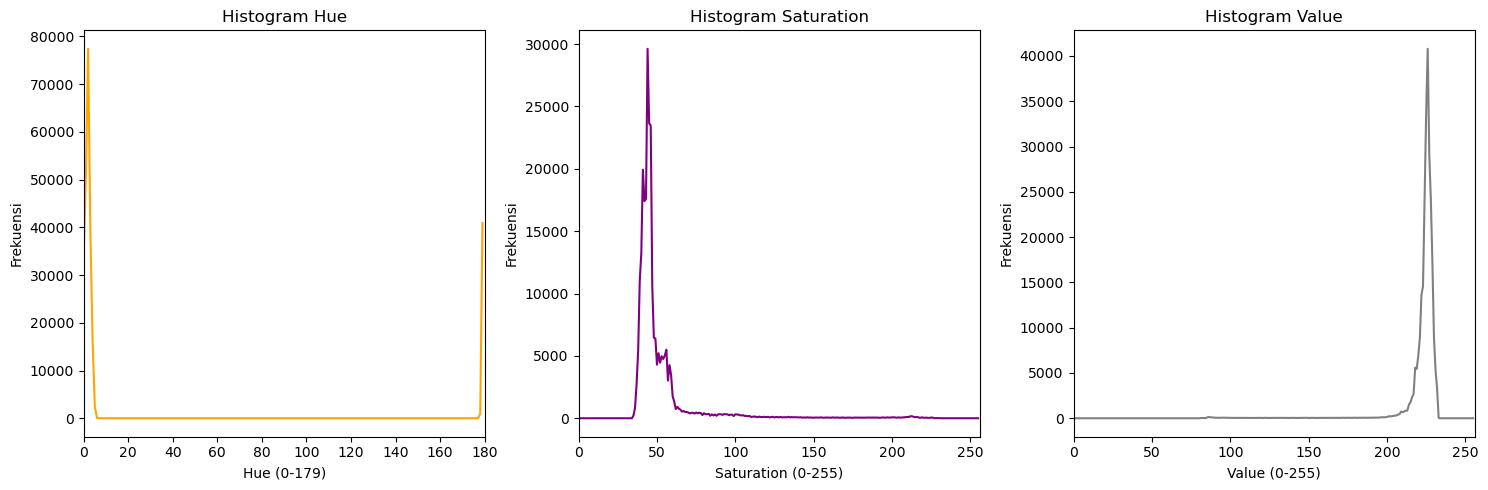

In [8]:
# HSV histogram analysis
h, s, v = cv2.split(image_hsv)

# Calculate HSV histograms
hist_hue = cv2.calcHist([image_hsv], [0], None, [180], [0, 180])
hist_sat = cv2.calcHist([image_hsv], [1], None, [256], [0, 256])
hist_val = cv2.calcHist([image_hsv], [2], None, [256], [0, 256])

# Plot RGB and HSV histograms together
plt.figure(figsize=(15, 5))

# HSV Histograms
plt.subplot(1, 3, 1)
plt.plot(hist_hue, color='orange')
plt.title("Histogram Hue")
plt.xlabel("Hue (0-179)")
plt.ylabel("Frekuensi")
plt.xlim([0, 180])

plt.subplot(1, 3, 2)
plt.plot(hist_sat, color='purple')
plt.title("Histogram Saturation")
plt.xlabel("Saturation (0-255)")
plt.ylabel("Frekuensi")
plt.xlim([0, 256])

plt.subplot(1, 3, 3)
plt.plot(hist_val, color='gray')
plt.title("Histogram Value")
plt.xlabel("Value (0-255)")
plt.ylabel("Frekuensi")
plt.xlim([0, 256])

plt.tight_layout()
plt.show()


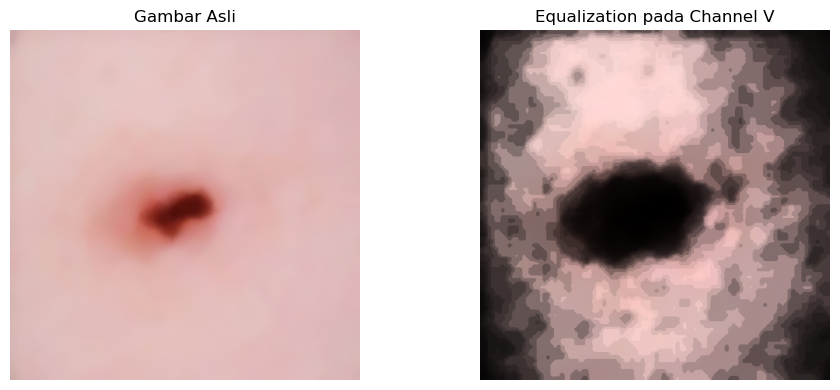

In [9]:
# Equalize hanya channel V
v_eq = cv2.equalizeHist(v)

# Gabungkan kembali
hsv_eq = cv2.merge([h, s, v_eq])

image_eq_rgb = cv2.cvtColor(hsv_eq, cv2.COLOR_HSV2RGB)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title('Gambar Asli')
plt.imshow(image)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Equalization pada Channel V')
plt.imshow(image_eq_rgb)
plt.axis('off')

plt.tight_layout()
plt.show()

### Reshape image to 2d array

In [11]:
pixel_vals = equalized_color_rgb.reshape((-1,3))
pixel_vals = np.float32(pixel_vals)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)

### AUTOMATIC K SELECTION

Testing k values: 3, 4, 5, 6, 7, 8, 

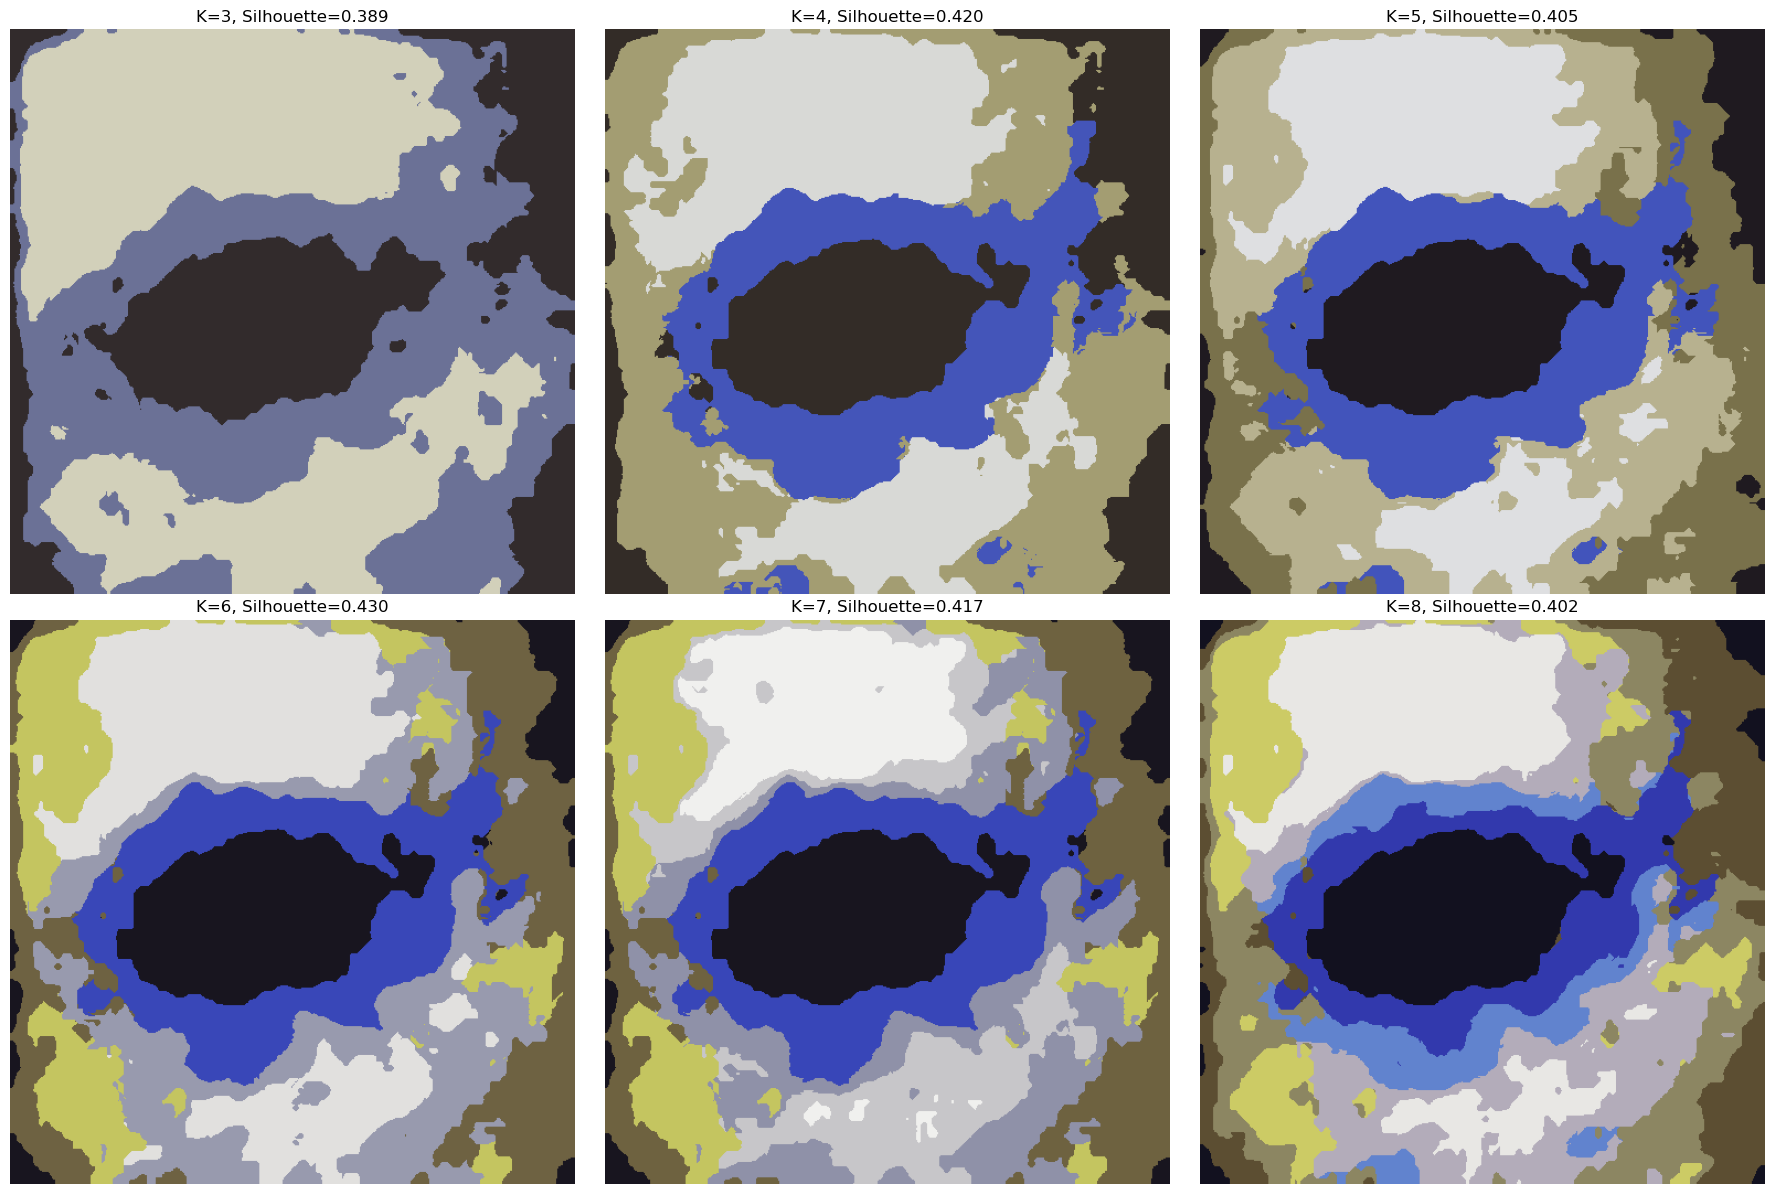

In [12]:
# OPTIMASI 1: Reduce image size for faster clustering
original_shape = equalized_color_rgb.shape
scale_factor = 0.25 
small_img = cv2.resize(equalized_color_rgb, 
                      (int(original_shape[1] * scale_factor), 
                       int(original_shape[0] * scale_factor)))

# OPTIMASI 2: Sample pixels instead of using all pixels
pixel_vals_small = small_img.reshape((-1,3))
pixel_vals_small = np.float32(pixel_vals_small)

# OPTIMASI 3: Further sampling if still too large
max_samples = 5000
if len(pixel_vals_small) > max_samples:
    indices = np.random.choice(len(pixel_vals_small), max_samples, replace=False)
    pixel_vals_sampled = pixel_vals_small[indices]
else:
    pixel_vals_sampled = pixel_vals_small

# Test different k values for automatic selection
k_range = [3, 4, 5, 6, 7, 8]
silhouette_scores = []
inertias = []
clustering_results = {}

# OPTIMASI 4: Reduced criteria for faster convergence
fast_criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 20, 1.0)

plt.figure(figsize=(18, 12))

print("Testing k values:", end=" ")
for i, k in enumerate(k_range):
    print(f"{k},", end=" ")
    retval, labels_small, centers = cv2.kmeans(pixel_vals_sampled, k, None, fast_criteria, 5, cv2.KMEANS_RANDOM_CENTERS)
    if len(np.unique(labels_small)) > 1:
        sil_score = silhouette_score(pixel_vals_sampled, labels_small.flatten())
        silhouette_scores.append(sil_score)
    else:
        silhouette_scores.append(0)
    inertias.append(retval)
    
    # Apply clustering to full resolution image for visualization
    retval_full, labels_full, centers_full = cv2.kmeans(pixel_vals, k, None, criteria, 5, cv2.KMEANS_RANDOM_CENTERS)
    clustering_results[k] = {
        'retval': retval_full,
        'labels': labels_full, 
        'centers': centers_full
    }
    
    # Visualize clustering results
    centers_vis = np.uint8(centers_full)
    segmented_data = centers_vis[labels_full.flatten()]
    segmented_image = segmented_data.reshape((equalized_color_rgb.shape))
    
    plt.subplot(2, 3, i+1)
    plt.imshow(segmented_image)
    plt.title(f'K={k}, Silhouette={silhouette_scores[i]:.3f}')
    plt.axis('off')

plt.tight_layout()
plt.show()


In [13]:
# Find optimal k
best_k_idx = np.argmax(silhouette_scores)
optimal_k = k_range[best_k_idx]
best_silhouette = silhouette_scores[best_k_idx]

print(f"Optimal k selected automatically: {optimal_k}")
print(f"Best silhouette score: {best_silhouette:.3f}")

Optimal k selected automatically: 6
Best silhouette score: 0.430


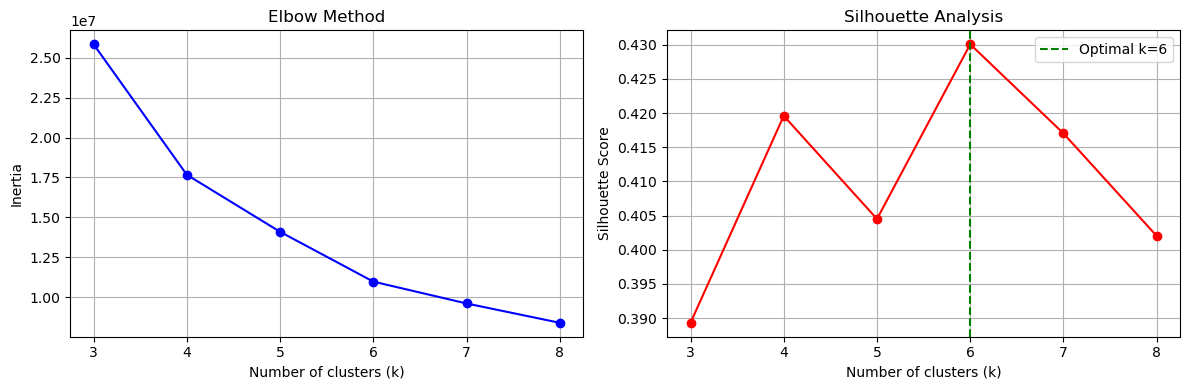

In [14]:
# Plot analysis charts
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(k_range, inertias, 'bo-')
plt.title('Elbow Method')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, 'ro-')
plt.title('Silhouette Analysis')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.axvline(x=optimal_k, color='green', linestyle='--', label=f'Optimal k={optimal_k}')
plt.legend()

plt.tight_layout()
plt.show()

(-0.5, 511.5, 511.5, -0.5)

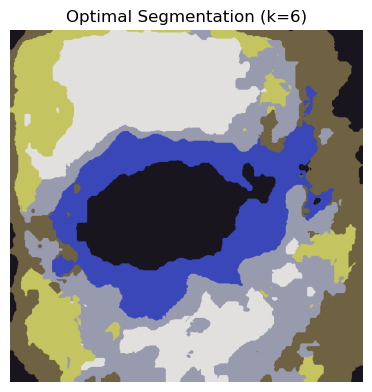

In [15]:
# Use optimal clustering result
k = optimal_k
retval, labels, centers = clustering_results[k]['retval'], clustering_results[k]['labels'], clustering_results[k]['centers']

centers = np.uint8(centers)
segmented_data = centers[labels.flatten()]
segmented_image = segmented_data.reshape((equalized_color_rgb.shape))
labels_reshape = labels.reshape(equalized_color_rgb.shape[0], equalized_color_rgb.shape[1])

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title(f'Optimal Segmentation (k={optimal_k})')
plt.imshow(segmented_image)
plt.axis('off')

### Mask image by cluster

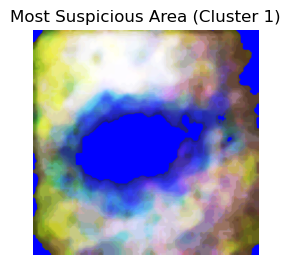

(512, 512, 3)


In [ ]:
# Simple automatic cluster selection based on darkness (typical melanoma characteristic)
unique_labels = np.unique(labels_reshape)
darkest_cluster = None
darkest_value = 255 

for cluster_id in unique_labels:
    mask = labels_reshape == cluster_id
    cluster_pixels = equalized_color_rgb[mask]
    mean_brightness = np.mean(cluster_pixels)
    
    if mean_brightness < darkest_value:
        darkest_value = mean_brightness
        darkest_cluster = cluster_id

# Automatic masking code
cluster = darkest_cluster 
masked_image = np.copy(equalized_color_rgb) # masih bingung pakai image/hasil equalized
masked_image[labels_reshape == cluster] = [BLUE]

plt.subplot(1, 2, 2)
plt.title(f'Most Suspicious Area (Cluster {cluster})')
plt.imshow(masked_image)
plt.axis('off')
plt.show()

print(masked_image.shape)